# Deep Q-Learning (DQN) - demo with 4 observations

Original Author: Adam Paszke<br>
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html<br>
Original code used state as screen image and Q_NN was ConvNet.

Modified by Xavier Bresson<br>
Modified code uses state as **4 observations** of cart pole and Q_NN is FCNN. 

Cart pole dataset:<br>
https://github.com/openai/gym/wiki/CartPole-v0


In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)  

In [4]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.08
EPS_END = 0.01
EPS_DECAY = 500 # half of num_episodes
TARGET_UPDATE = 50

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get number of input features from gym action space
input_dim = len(env.reset())
hidden_dim = 256
policy_net = DQN(input_dim, hidden_dim, n_actions).to(device)
target_net = DQN(input_dim, hidden_dim, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters()) 
memory = ReplayMemory(50000)

steps_done = 0

def select_action(state,i_episode):
    global steps_done
    sample = random.random()
    eps_threshold = max(EPS_END, EPS_START - (EPS_START - EPS_END)*(i_episode/float(EPS_DECAY)))
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        

In [5]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([torch.tensor(s).float() for s in batch.next_state
                                                if s is not None]).to(device)
    state_batch = torch.stack([torch.tensor(s).float() for s in batch.state]).to(device)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Mean reward for the last 100 episodes: 195.3000030517578
Complete


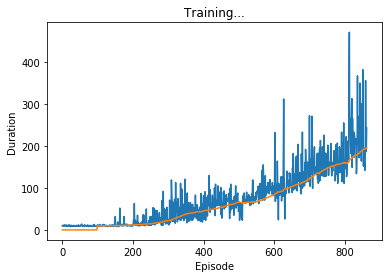

In [6]:
num_episodes = 1000
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.seed(torch.randint(1,10000,(1,)).item())
    state = env.reset() 
    for t in count():
        # Select and perform an action
        action = select_action(state,i_episode)
        next_state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        if done or t>1000:
            next_state = None
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        if done or t>1000:
            episode_durations.append(t + 1)
            plot_durations()
            break   
    # Perform one step of the optimization (on the target network)
    optimize_model()
    # stop when reward for the last 100 episodes is high
    reward100 = torch.tensor(episode_durations)[-100:].float().mean()
    print('Mean reward for the last 100 episodes:',reward100.item())
    if reward100 > env.spec.reward_threshold:
        break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
        target_net.eval()
        

print('Complete')
plot_durations()

In [ ]:
# run one episode
state = env.reset() 
for t in count():
    action = select_action(state,i_episode)
    state, _, done, _ = env.step(action.item())
    if done:
        break
    env.render()